## Import libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os

## Read and preprocess data


In [60]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id


In [61]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 10000}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Passengers_Oct21 = create_passengers_dict(Oct21)
Passengers_Oct22 = create_passengers_dict(Oct22)
Passengers_Oct23 = create_passengers_dict(Oct23)
Passengers_Oct24 = create_passengers_dict(Oct24)
Passengers_Oct30 = create_passengers_dict(Oct30)
Passengers_Nov5 = create_passengers_dict(Nov5)
Passengers_Nov7 = create_passengers_dict(Nov7)

# Static model

In [62]:
# Function to create optimization model and variables

ranks = 29  # number of rows in the aircraft
number_of_seats = 7 * ranks 
 
# We need a bigger aircraft for Nov7:
ranks_Nov7 = 35  # number of rows in the aircraft
number_of_seats_Nov7 = 7 * ranks_Nov7 

def create_model_and_variables(passengers_dict, ns):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(quicksum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(quicksum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    m.addConstr(y_g >= 13)
    m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7): 
                
                # I think we need to create an if : if ns = number_of_seats: code below  . Else : for j in range(1, ns+1-15, 14):          
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] +  S[(passenger, x6)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+6)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

In [63]:
# Create models and variables for each date
m_Oct21, S_Oct21 = create_model_and_variables(Passengers_Oct21, number_of_seats)
m_Oct22, S_Oct22 = create_model_and_variables(Passengers_Oct22, number_of_seats)
m_Oct23, S_Oct23 = create_model_and_variables(Passengers_Oct23, number_of_seats)
m_Oct24, S_Oct24 = create_model_and_variables(Passengers_Oct24, number_of_seats)
m_Oct30, S_Oct30 = create_model_and_variables(Passengers_Oct30, number_of_seats)
m_Nov5, S_Nov5 = create_model_and_variables(Passengers_Nov5, number_of_seats)
m_Nov7, S_Nov7 = create_model_and_variables(Passengers_Nov7, number_of_seats_Nov7)

Objective functions

In [64]:
# Transit passengers are seated at the front of the aircraft
def obj_transit(S, passengers_dict, ns):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f


In [65]:
#creates coordinates for the seats
def seat_coordinates(seats):
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

In [66]:
#Function to allocate passengers to the same group
alpha=0.3

def obj_dist(m, S, Passengers, alpha, ns):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, len(Passengers) + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, len(Passengers) + 1):  
            #If passenger i and passenger k are in the same group
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj


In [67]:

m_Oct21.setObjective(obj_transit(S_Oct21, Passengers_Oct21, number_of_seats) + obj_dist(m_Oct21, S_Oct21, Passengers_Oct21, alpha, number_of_seats) , GRB.MINIMIZE)
m_Oct22.setObjective(obj_transit(S_Oct22, Passengers_Oct22, number_of_seats) + obj_dist(m_Oct22, S_Oct22, Passengers_Oct22, alpha, number_of_seats), GRB.MINIMIZE)
m_Oct23.setObjective(obj_transit(S_Oct23, Passengers_Oct23, number_of_seats) + obj_dist(m_Oct23, S_Oct23, Passengers_Oct23, alpha, number_of_seats), GRB.MINIMIZE)
m_Oct24.setObjective(obj_transit(S_Oct24, Passengers_Oct24, number_of_seats) + obj_dist(m_Oct24, S_Oct24, Passengers_Oct24, alpha, number_of_seats), GRB.MINIMIZE)
m_Oct30.setObjective(obj_transit(S_Oct30, Passengers_Oct30, number_of_seats) + obj_dist(m_Oct30, S_Oct30, Passengers_Oct30, alpha, number_of_seats), GRB.MINIMIZE)
m_Nov5.setObjective(obj_transit(S_Nov5, Passengers_Nov5, number_of_seats) + obj_dist(m_Nov5, S_Nov5, Passengers_Nov5, alpha, number_of_seats), GRB.MINIMIZE)
m_Nov7.setObjective(obj_transit(S_Nov7, Passengers_Nov7, number_of_seats_Nov7) + obj_dist(m_Nov7, S_Nov7, Passengers_Nov7, alpha, number_of_seats_Nov7), GRB.MINIMIZE)

In [68]:
# Choice of minimalist display settings
m_Oct21.params.outputflag = 0 # mute mode
m_Oct21.update() # Model update
display(m_Oct21) # Text mode display of PL

m_Oct22.params.outputflag = 0
m_Oct22.update()
display(m_Oct22)

m_Oct23.params.outputflag = 0
m_Oct23.update()
display(m_Oct23)

m_Oct24.params.outputflag = 0
m_Oct24.update()
display(m_Oct24)

m_Oct30.params.outputflag = 0
m_Oct30.update()
display(m_Oct30)

m_Nov5.params.outputflag = 0 
m_Nov5.update()
display(m_Nov5)

m_Nov7.params.outputflag = 0
m_Nov7.update()
display(m_Nov7)

<gurobi.Model MIP instance statique: 4925 constrs, 30955 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

<gurobi.Model MIP instance statique: 3787 constrs, 23780 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

<gurobi.Model MIP instance statique: 6237 constrs, 35465 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

<gurobi.Model MIP instance statique: 6163 constrs, 33620 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

<gurobi.Model MIP instance statique: 5248 constrs, 23575 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

<gurobi.Model MIP instance statique: 4193 constrs, 19885 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

<gurobi.Model MIP instance statique: 8740 constrs, 40014 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

Resolution

In [69]:
#Resolution
m_Oct21.Params.timeLimit = 120.0
m_Oct21.optimize()
# Solution display 
print()
print("Seats on the plane for Oct21 are as follows:", [(i, j) for i in range(1, len(Passengers_Oct21) + 1) for j in range(1, number_of_seats + 1) if S_Oct21[(i, j)].x])

m_Oct22.Params.timeLimit = 120.0
m_Oct22.optimize()
print()
print("Seats on the plane for Oct22 are as follows:", [(i, j) for i in range(1, len(Passengers_Oct22) + 1) for j in range(1, number_of_seats + 1) if S_Oct22[(i, j)].x])

m_Oct23.Params.timeLimit = 120.0
m_Oct23.optimize()
print()
print("Seats on the plane for Oct23 are as follows:", [(i, j) for i in range(1, len(Passengers_Oct23) + 1) for j in range(1, number_of_seats + 1) if S_Oct23[(i, j)].x])

m_Oct24.Params.timeLimit = 120.0
m_Oct24.optimize()
print()
print("Seats on the plane for Oct24 are as follows:", [(i, j) for i in range(1, len(Passengers_Oct24) + 1) for j in range(1, number_of_seats + 1) if S_Oct24[(i, j)].x])

m_Oct30.Params.timeLimit = 120.0
m_Oct30.optimize()
print()
print("Seats on the plane for Oct30 are as follows:", [(i, j) for i in range(1, len(Passengers_Oct30) + 1) for j in range(1, number_of_seats + 1) if S_Oct30[(i, j)].x])

m_Nov5.Params.timeLimit = 120.0
m_Nov5.optimize()
print()
print("Seats on the plane for Nov5 are as follows:", [(i, j) for i in range(1, len(Passengers_Nov5) + 1) for j in range(1, number_of_seats + 1) if S_Nov5[(i, j)].x])

m_Nov7.Params.timeLimit = 120.0
m_Nov7.optimize() # AttributeError: Unable to retrieve attribute 'x'
print()
print("Seats on the plane for Nov7 are as follows:", [(i, j) for i in range(1, len(Passengers_Nov7) + 1) for j in range(1, number_of_seats_Nov7 + 1) if S_Nov7[(i, j)].x])


Seats on the plane for Oct21 are as follows: [(1, 34), (2, 184), (3, 153), (4, 129), (5, 103), (6, 104), (7, 174), (8, 78), (9, 36), (10, 37), (11, 73), (12, 181), (13, 98), (14, 97), (15, 28), (16, 155), (17, 112), (18, 111), (19, 96), (20, 40), (21, 79), (22, 80), (23, 70), (24, 121), (25, 114), (26, 115), (27, 113), (28, 13), (29, 20), (30, 21), (31, 19), (32, 127), (33, 128), (34, 17), (35, 6), (36, 5), (37, 176), (38, 177), (39, 35), (40, 126), (41, 143), (42, 142), (43, 89), (44, 101), (45, 83), (46, 51), (47, 50), (48, 189), (49, 94), (50, 42), (51, 41), (52, 24), (53, 23), (54, 138), (55, 84), (56, 91), (57, 62), (58, 63), (59, 1), (60, 136), (61, 192), (62, 180), (63, 154), (64, 161), (65, 160), (66, 29), (67, 33), (68, 22), (69, 110), (70, 148), (71, 119), (72, 118), (73, 12), (74, 14), (75, 164), (76, 134), (77, 135), (78, 162), (79, 163), (80, 47), (81, 48), (82, 120), (83, 26), (84, 27), (85, 71), (86, 170), (87, 171), (88, 124), (89, 65), (90, 64), (91, 76), (92, 167), (

Visualization of the seats

In [70]:
# Display the Baricenter

def calculate_center_of_mass(S, passengers_dict, ns):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, len(passengers_dict) + 1)).getValue()

    for i in range(1, len(passengers_dict) + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j].x * weight_ij)
                y_g += (j_k * S[i, j].x * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j].x * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j].x * weight_ij)

    return x_g, y_g


In [71]:
x_g_Oct21, y_g_Oct21 = calculate_center_of_mass(S_Oct21, Passengers_Oct21, number_of_seats)
x_g_Oct22, y_g_Oct22 = calculate_center_of_mass(S_Oct22, Passengers_Oct22, number_of_seats)
x_g_Oct23, y_g_Oct23 = calculate_center_of_mass(S_Oct23, Passengers_Oct23, number_of_seats)
x_g_Oct24, y_g_Oct24 = calculate_center_of_mass(S_Oct24, Passengers_Oct24, number_of_seats)
x_g_Oct30, y_g_Oct30 = calculate_center_of_mass(S_Oct30, Passengers_Oct30, number_of_seats)
x_g_Nov5, y_g_Nov5 = calculate_center_of_mass(S_Nov5, Passengers_Nov5, number_of_seats)
x_g_Nov7, y_g_Nov7 = calculate_center_of_mass(S_Nov7, Passengers_Nov7, number_of_seats_Nov7)

In [72]:
seats_Oct21 = [j for i in range(1, len(Passengers_Oct21) + 1) for j in range(1, number_of_seats + 1) if S_Oct21[(i, j)].x]
seat_coords_Oct21 = seat_coordinates(seats_Oct21)

seats_Oct22 = [j for i in range(1, len(Passengers_Oct22) + 1) for j in range(1, number_of_seats + 1) if S_Oct22[(i, j)].x]
seat_coords_Oct22 = seat_coordinates(seats_Oct22)

seats_Oct23 = [j for i in range(1, len(Passengers_Oct23) + 1) for j in range(1, number_of_seats + 1) if S_Oct23[(i, j)].x]
seat_coords_Oct23 = seat_coordinates(seats_Oct23)

seats_Oct24 = [j for i in range(1, len(Passengers_Oct24) + 1) for j in range(1, number_of_seats + 1) if S_Oct24[(i, j)].x]
seat_coords_Oct24 = seat_coordinates(seats_Oct24)

seats_Oct30 = [j for i in range(1, len(Passengers_Oct30) + 1) for j in range(1, number_of_seats + 1) if S_Oct30[(i, j)].x]
seat_coords_Oct30 = seat_coordinates(seats_Oct30)

seats_Nov5 = [j for i in range(1, len(Passengers_Nov5) + 1) for j in range(1, number_of_seats + 1) if S_Nov5[(i, j)].x]
seat_coords_Nov5 = seat_coordinates(seats_Nov5)

seats_Nov7 = [j for i in range(1, len(Passengers_Nov7) + 1) for j in range(1, number_of_seats_Nov7 + 1) if S_Nov7[(i, j)].x]
seat_coords_Nov7 = seat_coordinates(seats_Nov7)

In [73]:
def plot_seating(passengers_dict, seat_coords, x_g, y_g):
    # Counting the frequency of each group
    group_counts = defaultdict(int)

    for passenger in passengers_dict.values():
        group_counts[passenger['group']] += 1

    # Sort the groups by the number of passengers in each group in descending order
    sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

    # Define shapes for each gender
    shapes = {
        'Women': 'o',   # Circle
        'Men': 's',     # Square
        'WCHR': '^'     # Triangle
    }

    # Define colors for the groups with 3 passangers
    colors = {
        23: 'red',
        9: 'green',
        29: 'blue',
        30: 'darkorange',
        36: 'purple',
        44: 'gray',
        7: 'cyan',
        3 : 'springgreen',
        16: 'yellow',
        42: 'saddlebrown',
        46: 'deeppink'
    }

    plt.figure(figsize=(10, 10))
    for idx, coord in enumerate(seat_coords):
        group = passengers_dict[idx + 1]['group']
        gender = passengers_dict[idx + 1]['gender']
        color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
        shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
        plt.scatter(coord[0], coord[1], color=color, marker=shape)  # Use marker parameter to set the shape

    # Add labels for each gender
    for gender, shape in shapes.items():
        plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

    # Plotting the center of mass
    plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', label="center of mass", s=150)  # Larger red point for center of mass

    plt.xlabel('Col')
    plt.ylabel('Row')
    plt.title('Seat')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()


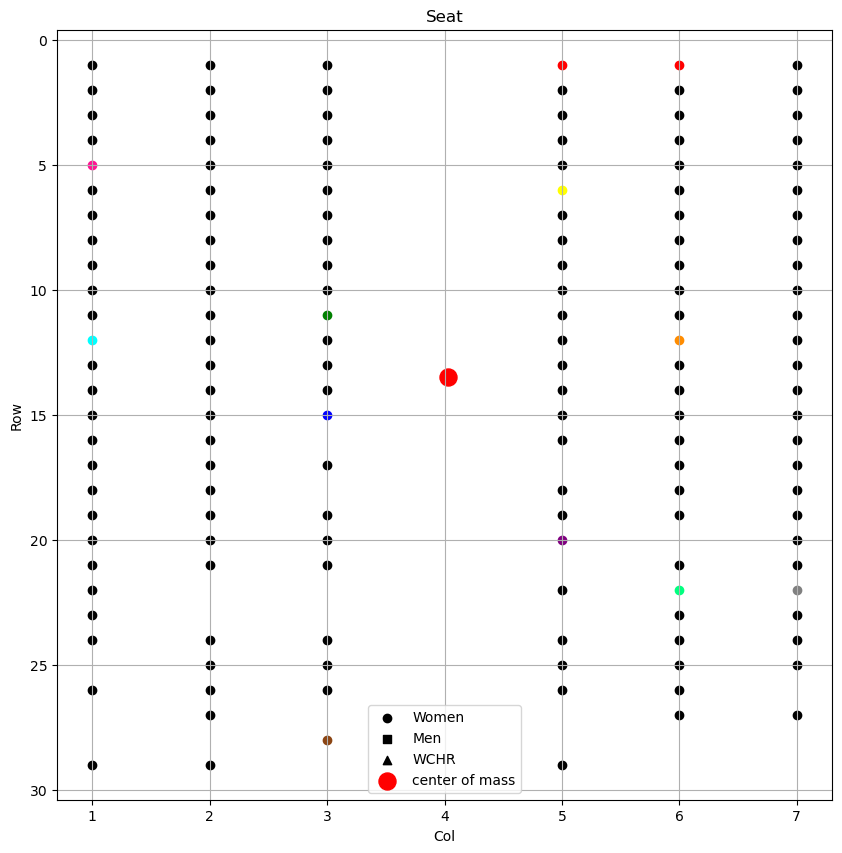

In [74]:
plot_seating(Passengers_Oct21, seat_coords_Oct21, x_g_Oct21, y_g_Oct21)

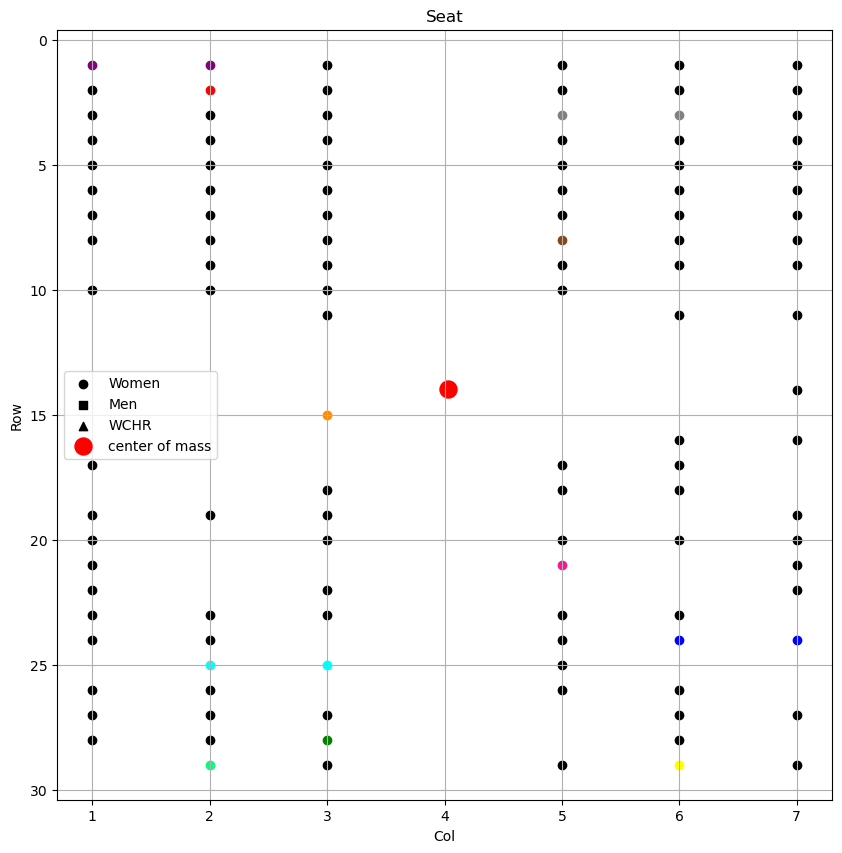

In [75]:
plot_seating(Passengers_Oct22, seat_coords_Oct22, x_g_Oct22, y_g_Oct22)

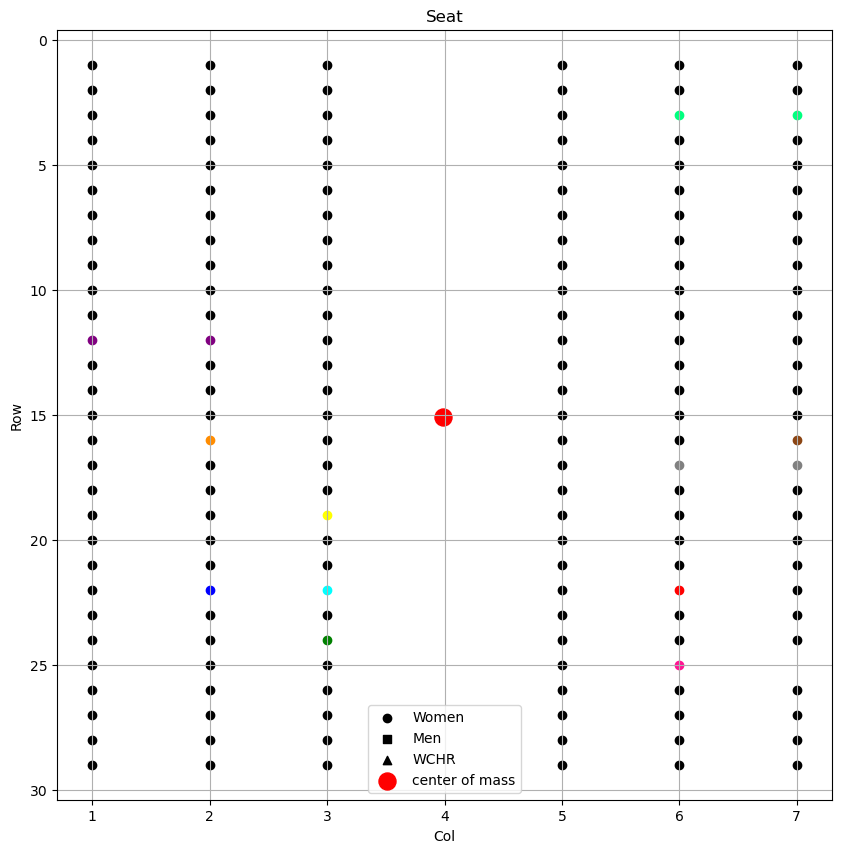

In [76]:
plot_seating(Passengers_Oct23, seat_coords_Oct23, x_g_Oct23, y_g_Oct23)

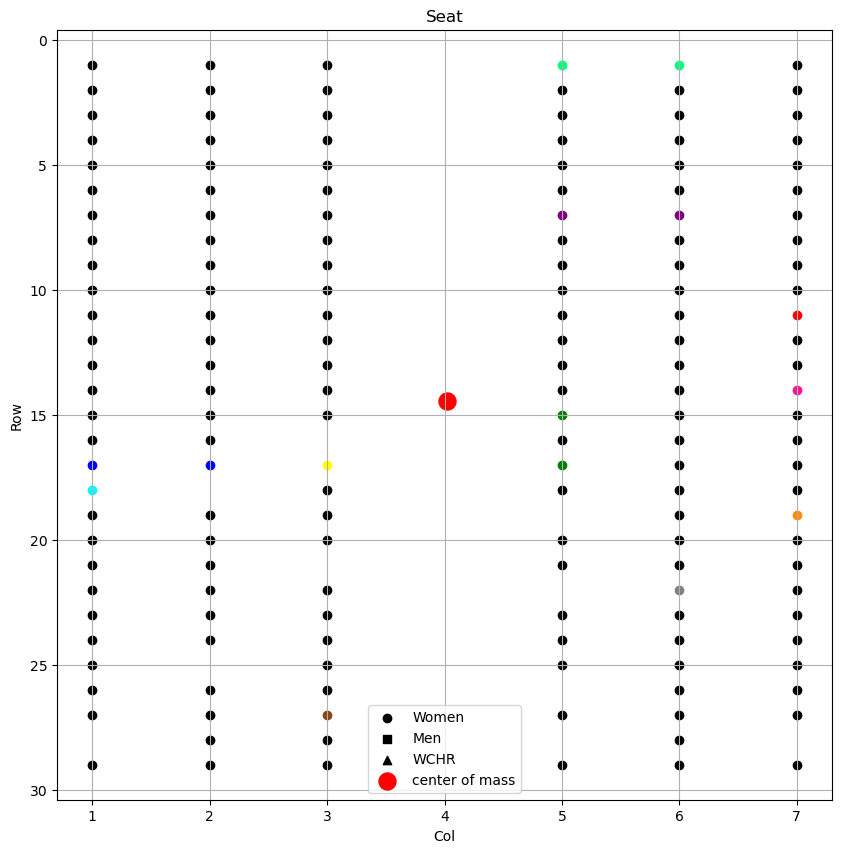

In [77]:
plot_seating(Passengers_Oct24, seat_coords_Oct24, x_g_Oct24, y_g_Oct24)

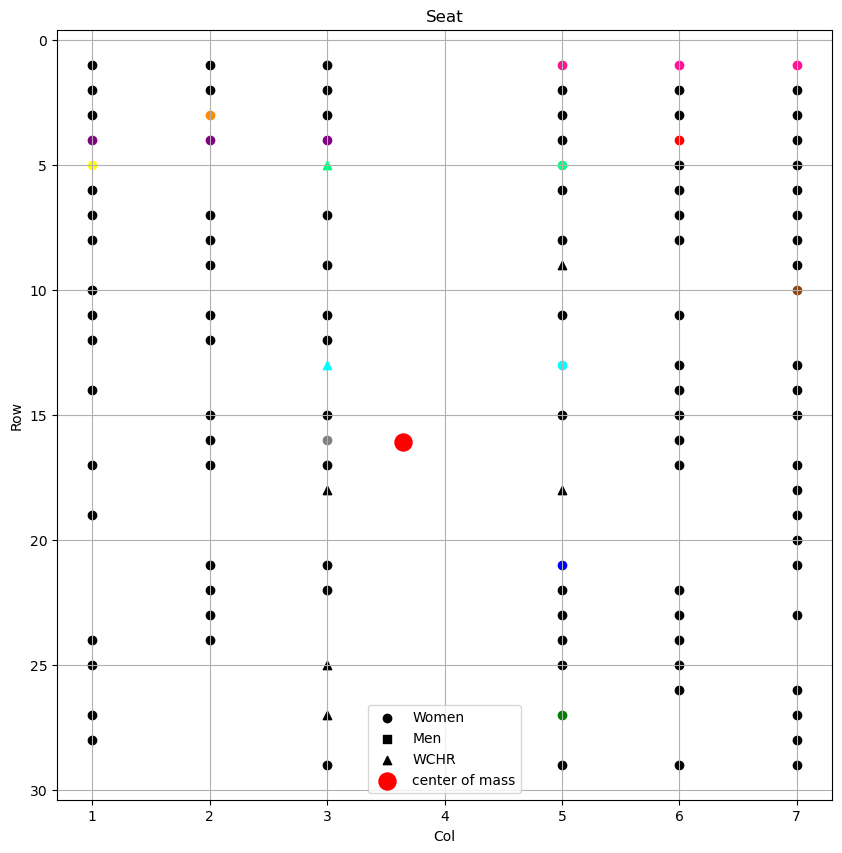

In [78]:
plot_seating(Passengers_Oct30, seat_coords_Oct30, x_g_Oct30, y_g_Oct30)

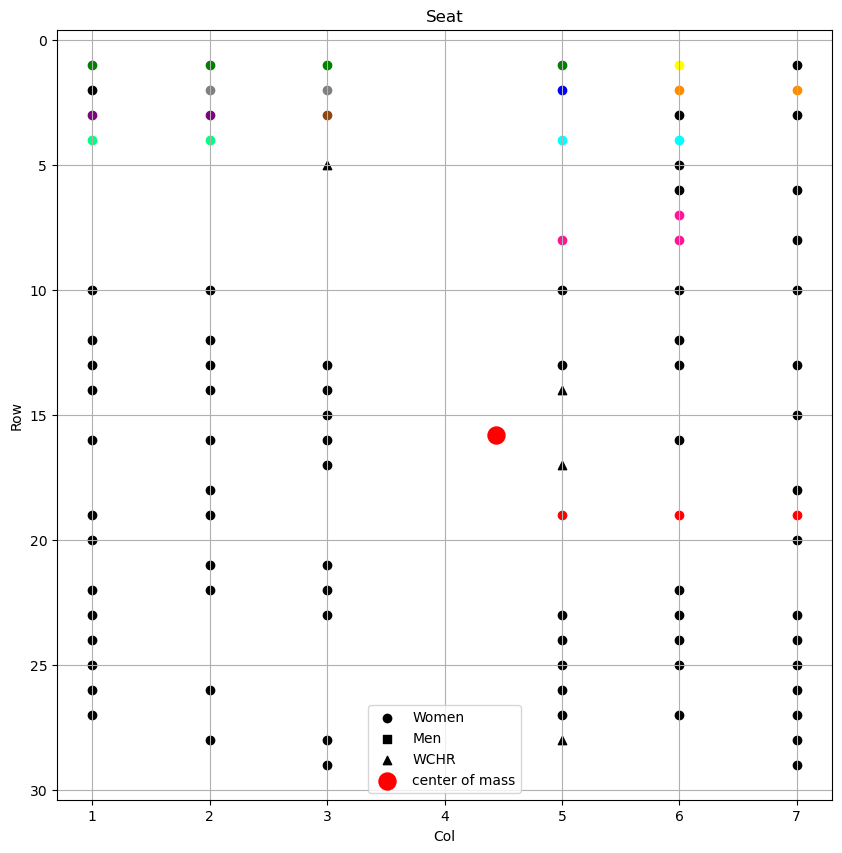

In [79]:
plot_seating(Passengers_Nov5, seat_coords_Nov5, x_g_Nov5, y_g_Nov5)

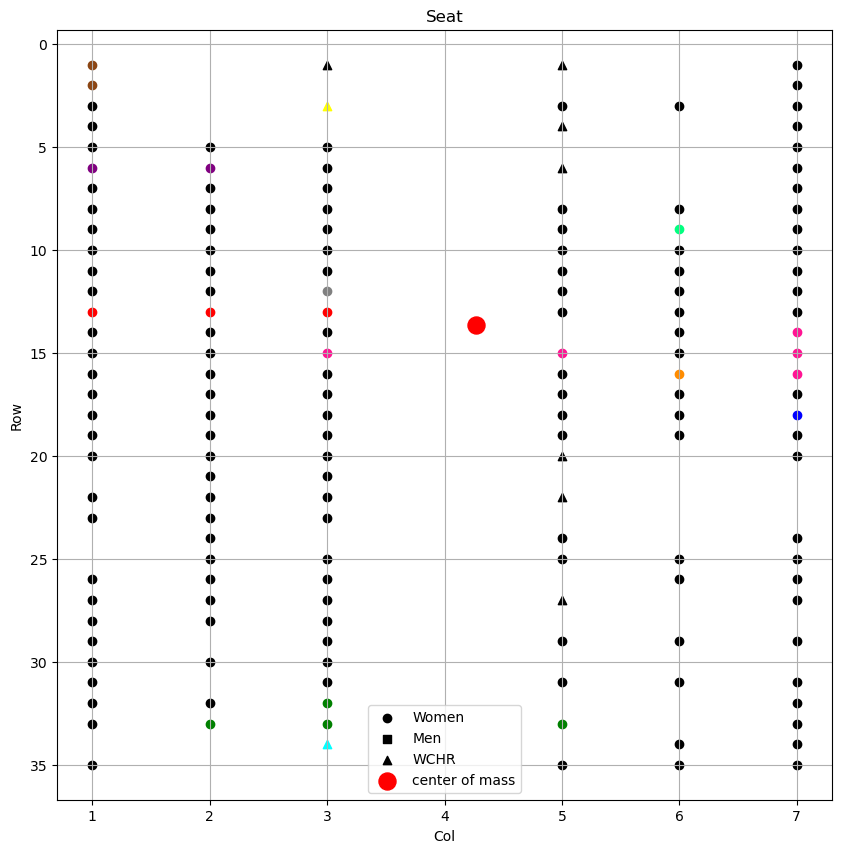

In [80]:
plot_seating(Passengers_Nov7, seat_coords_Nov7, x_g_Nov7, y_g_Nov7)